# Model Exploration

### By Grant Lewis

I started by first working with a Random Forest model. I then moved to working with XGBoost. I decided to build a few classes to simplify testing several different versions of these two model architectures.  I also decided to try incorporating PCA in an attempt to improve results. When neither seemed to be very succesful, I decided to try a simple deep neural network using pytorch.

Inevitably, I was not completely satisfied with the results due to low evaluation results.  Given more time, I could have experimented other models and methods that could have produced better results. Generally, I would not include so many intermediate steps in my reports.  However, I chose to includ more of my raw experimentation and impressions to help illustrate my thought process and the steps I took to try to improve the model.

### Imports and Setup

In [88]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import os

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from joblib import dump, load


import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from time import time


# INPUT_DATA = "./data/normalized.csv"
INPUT_DATA = "./data/normalized_with_dummies_no_na.csv"

TARGET = "loan_status"

df_orig = pd.read_csv(INPUT_DATA)


object_columns = df_orig.select_dtypes(include=['O']).columns
for col in object_columns:
    df_orig[col] = df_orig[col].astype('category')

df_orig.head()

,funded_amnt,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,earliest_cr_line,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,35000,60,0.2549,1037.38,10.0,59000.00,1,25.28,1,66.000000,...,0,0,0,0,0,0,0,0,0,0
1,40000,36,0.0724,1239.48,0.0,20000.00,1,114.65,0,341.933333,...,0,0,0,0,0,0,0,0,0,0
2,25000,60,0.2869,788.84,0.0,77000.00,-3,42.78,10,313.566667,...,0,0,0,0,0,0,0,0,0,0
3,6000,36,0.0799,188.00,0.0,38683.61,2,10.40,1,205.966667,...,0,0,0,0,0,0,0,0,0,0
4,10000,36,0.0749,311.02,0.0,60000.00,2,48.08,0,235.400000,...,0,0,0,0,0,0,0,0,0,0


In [89]:
class PCAWrapper:
    # A wrapper for PCA that includes a StandardScaler and a plot function
    def __init__(self, n_components, X=None, quiet=True):
        self.n_components = n_components
        self.standardscaler = StandardScaler()
        self.pca = PCA(n_components=n_components)
        if X is not None:
            self.fit(X)
            if not quiet:
                self.plot()
    
    def fit(self, X):
        X = self.standardscaler.fit_transform(X)
        self.pca.fit(X)
    
    def transform(self, X):
        X = self.standardscaler.transform(X)
        return self.pca.transform(X)
    
    def fit_transform(self, X):
        X = self.standardscaler.fit_transform(X)
        return self.pca.fit_transform(X)
    
    def inverse_transform(self, X):
        return self.standardscaler.inverse_transform(self.pca.inverse_transform(X))
    
    def explained_variance_ratio(self):
        return self.pca.explained_variance_ratio_
    
    def components(self):
        return self.pca.components_
    
    def plot(self):
        # Optional: Plot the cumulative explained variance to choose n_components
        plt.figure(figsize=(8, 5))
        plt.plot(np.cumsum(self.pca.explained_variance_ratio_))
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Explained Variance by Number of Components')
        plt.grid(True)
        plt.show()
    
    def info(self):
        print("Explained variance by component:")
        print(self.pca.explained_variance_ratio_)

        # Print the cumulative explained variance
        print("Cumulative explained variance:")
        print(self.pca.explained_variance_ratio_.cumsum())
        
    def save(self, file_path, scalar_file_path=None):
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        
        if scalar_file_path is None:
            scalar_file_path = file_path.split(".")[0] + "_scalar.joblib"
        dump(self.standardscaler, scalar_file_path)
        dump(self.pca, file_path)

    def load(self, file_path, scalar_file_path=None):
        if scalar_file_path is None:
            scalar_file_path = file_path.split(".")[0] + "_scalar.joblib"
        self.standardscaler = load(scalar_file_path)
        self.pca = load(file_path)
        


class Dataset:
    # Allows for quickly and easily resetting the dataset in a desired manner
    def __init__(self, df, target_col, test_size=0.2, use_pca=False, pca_n_components=100):
        self.df_orig = df.copy()
        self.df = df
        self.target_col = target_col
        self.test_size = test_size
        self.pca = None
        self.use_pca = use_pca
        self.pca_n_components = pca_n_components
        self.reset_variables()
        self.pca = None if not use_pca else PCAWrapper(n_components=pca_n_components, X=self.X, quiet=False)
        
    def set_df(self, df=None):
        # Resets the dataframe to the original or a new one
        if df is None:
            df = self.df_orig.copy()
        self.df = df
        return self.reset_variables()
    
    def set_pca(self, use_pca, scalar_path=None, pca_n_components=100):
        # Allows for setting the PCA object or loading it from a file
        if isinstance(use_pca, PCAWrapper):
            self.use_pca = True
            self.pca = use_pca
        elif isinstance(use_pca, str):
            self.use_pca = True
            self.pca = PCAWrapper(n_components=pca_n_components)
            self.pca.load(use_pca, scalar_path)
        elif isinstance(use_pca, bool):
            self.use_pca = use_pca
            self.pca_n_components = pca_n_components
            self.pca = None if not use_pca else PCAWrapper(n_components=pca_n_components, X=self.X, quiet=False)
        return self.reset_variables()
        
    def reset_variables(self):
        # Recalculates the X, y, X_train, X_test, y_train, and y_test variables
        self.X = self.df.drop(self.target_col, axis=1)
        self.y = self.df[[self.target_col]]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=self.test_size, random_state=42)
        if self.pca is not None:
            self.X_train = self.pca.fit_transform(self.X_train)
            self.X_test = self.pca.transform(self.X_test)
        return self
    
    def downsample(self, modifier=1):
        # Downsamples the dataset to the size of the smallest class multiplied by the modifier
        # NOTE: Run this after running map_target if you plan to change the target values
        min_class_size = self.df[self.target_col].value_counts().min()
        min_class_size = int(min_class_size * modifier)
        print(f"Min class size: {min_class_size}")

        new_df = self.df.groupby(self.target_col).apply(lambda x: x.sample(min_class_size, random_state=42) if len(x) > min_class_size else x).reset_index(drop=True)
        self.df = new_df
        return self.reset_variables()
     
    def map_target(self, target_map):
        # Maps the target column to a new set of values. Drops any values that do not have a key present in target_map
        keys_to_remove = [x for x in self.df[self.target_col].unique().tolist() if x not in target_map.keys()]
        self.df = self.df[~self.df[self.target_col].isin(keys_to_remove)]
        self.df[self.target_col] = self.df[self.target_col].map(target_map)
        return self.reset_variables()

    def get_train(self):
        return self.X_train, self.y_train
    
    def get_test(self):
        return self.X_test, self.y_test

    


class TreeModel:
    # A class to allow for quickly training and testing a tree-based model (RandomForest or XGBoost)
    def __init__(self, is_xgboost=False, enable_categorical=True, save_file_path=None, class_weight=None):
        self.is_xgboost = is_xgboost
        self.enable_categorical = enable_categorical
        self.save_file_path = save_file_path
        self.class_weight = class_weight
        self.clf = None

    def train(self, X_train, y_train):
        # Trains the model on the given data
        if self.is_xgboost:
            self.clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=self.enable_categorical)
            # self.clf = xgb.XGBRegressor(n_estimators=100, learning_rate=1, 
            #            objective='reg:squarederror', subsample=1, reg_lambda=0.1)
        else:
            max_y = y_train[TARGET].max()
            
            class_weight = {x: 1 for x in y_train[TARGET].unique().tolist()}
            if self.class_weight is not None:
                class_weight[max_y] = self.class_weight
                ## Alt:
                # for key in class_weight.keys():
                #     if key != max_y:
                #         class_weight[key] = self.class_weight
            print(class_weight)
            self.clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight)

        self.clf.fit(X_train, y_train)
        if self.save_file_path:
            self.clf.save_model(self.save_file_path)
        return self.clf
    
    def predict(self, X_test):
        # Predicts the target variable for the given data
        y_pred = self.clf.predict(X_test)
        return y_pred
    
    def test(self, X_test, y_test):
        # Predicts the target variable for the given data and compares it to the actual values
        # Prints out the accuracy, precision, recall, and F1 score and returns the confusion matrix
        y_pred = self.predict(X_test)
        
        print(y_pred[:10])
        y_pred = y_pred.round()
        
        print(y_pred.shape, y_test.shape)
        
        accuracy = accuracy_score(y_test, y_pred)
        method = "weighted"
        precision = precision_score(y_test, y_pred, average=method)
        recall = recall_score(y_test, y_pred, average=method)
        f1 = f1_score(y_test, y_pred, average=method)
        
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1: {f1:.2f}")
        
        cm = confusion_matrix(y_test, y_pred)
        labels = y_test[TARGET].unique().tolist()
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)
        ordered_labels = sorted(labels)
        cm_df = cm_df.reindex(index=ordered_labels, columns=ordered_labels) #, fill_value=0) 
        
        # print(cm)

        # return cm
        print(cm_df)
        return cm_df

    def plot_confusion_matrix(self, cm, labels):
        # Plots the confusion matrix
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False) #, xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()
    
    def save(self, file_path):
        if self.is_xgboost:
            self.clf.save_model(file_path)
        else:
            dump(self.clf, file_path)
        return self.clf
        
    def load(self, file_path):
        if self.is_xgboost:
            self.clf = xgb.XGBClassifier()
            self.clf.load_model(file_path)
        else:
            self.clf = load(file_path)
        return self.clf
        
        
    


In [90]:
# Initializing the dataset class
data = Dataset(df_orig.copy(), TARGET)

### Random Forest

After a few quick tests, it became clear that some form of resampling was necessary to have a chance at a good model. I decided to downsample the majority classes. While not as ideal as making synthetic data, downsampling is a simple and effective way to balance the classes.


Min class size: 34
{2: 1, 3: 1, 5: 1, 1: 1, 4: 1, 0: 1}
[3 1 0 5 1 3 5 0 1 1]
(39,) (39, 1)
Accuracy: 0.21
Precision: 0.26
Recall: 0.21
F1: 0.22
   0  1  2  3  4  5
0  3  0  0  2  2  3
1  1  2  0  0  4  1
2  1  2  0  0  1  1
3  1  0  0  1  4  1
4  0  2  0  2  0  1
5  0  0  0  0  2  2


c:\Users\grant\anaconda3\envs\xgboost_gpu\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\grant\anaconda3\envs\xgboost_gpu\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


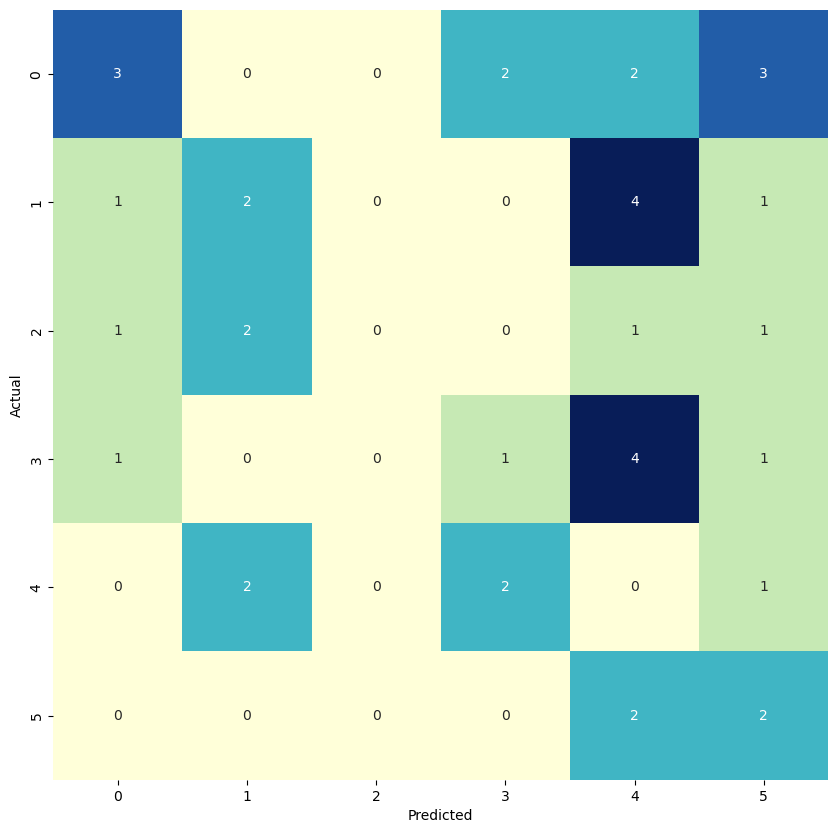

In [91]:
TARGET_MAP = {2 : 5, # Fully Paid
                1 : 4, # Current
                0 : 3, # In Grace Period
                -1 : 2, # Late (16-30 days)
                -2 : 1, # Late (31-120 days)
                -3 : 0, # Charged Off
                }

data.set_df().map_target(TARGET_MAP).downsample(1.5)
X_train, y_train = data.get_train()
X_test, y_test = data.get_test()

model = TreeModel(is_xgboost=False, enable_categorical=True, class_weight=None)
model.train(X_train, y_train)
cm = model.test(X_test, y_test)
model.plot_confusion_matrix(cm, y_test[TARGET].unique())

I frist decided to try building a model that worked with the original classes. I expected the results to be less than favorable, especially given that there were 5 classes, but wanted to see how it would perform.  Results were so low that I concidered not even including it, 

Min class size: 287
{0: 1, 1: 1}
[1 0 0 1 1 0 0 1 1 1]
(115,) (115, 1)
Accuracy: 0.59
Precision: 0.59
Recall: 0.59
F1: 0.59
    0   1
0  29  22
1  25  39


c:\Users\grant\anaconda3\envs\xgboost_gpu\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


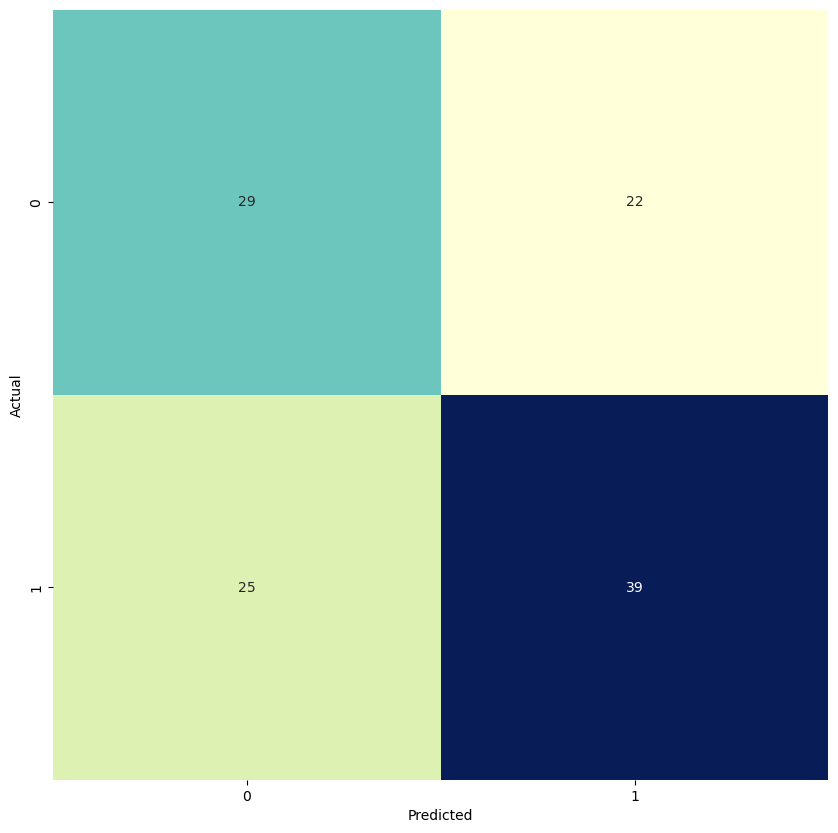

In [113]:
TARGET_MAP = {2 : 1, # Fully Paid
                1 : 1, # Current
                0 : 0, # In Grace Period
                -1 : 0, # Late (16-30 days)
                -2 : 0, # Late (31-120 days)
                -3 : 0, # Charged Off
                }

data.set_df().map_target(TARGET_MAP).downsample(1)
X_train, y_train = data.get_train()
X_test, y_test = data.get_test()

model = TreeModel(is_xgboost=False, enable_categorical=True, class_weight=None)
model.train(X_train, y_train)
cm = model.test(X_test, y_test)
model.plot_confusion_matrix(cm, y_test[TARGET].unique())



I then decided to focus on binary classification since results generally are better than trying to work with more classes. I started by grouping "Current" with "Fully Paid" in one class and everything else in another.  I also ran a similar test where the classes were "Fully Paid" or not. I only showed the results of the later since they were similar. The downsampling helped alot in allowing for predictions of the "Fully Paid" class.  Since our goal is to know which loans to invest in, we really want to maximize our positive precision (lower the false positives). I decided to add a strong class weight to the "Fully Paid" class to help with this:

{0: 1, 1: 1.5}
[1 0 0 0 1 0 0 1 1 1]
(115,) (115, 1)
Accuracy: 0.68
Precision: 0.68
Recall: 0.68
F1: 0.68
    0   1
0  34  17
1  20  44


c:\Users\grant\anaconda3\envs\xgboost_gpu\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


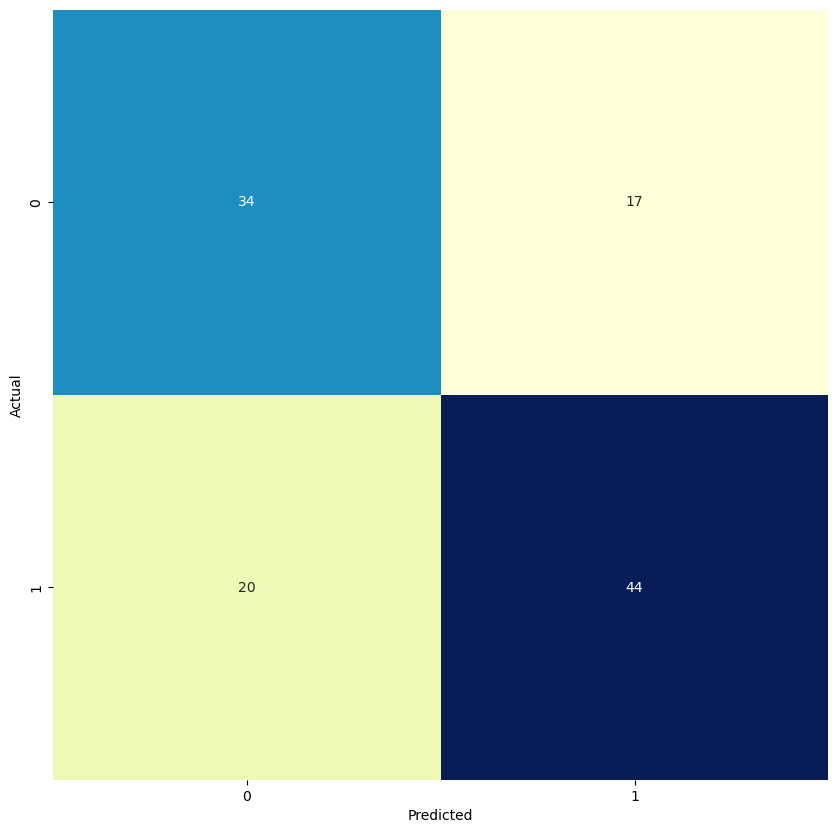

In [119]:
model = TreeModel(is_xgboost=False, enable_categorical=True, class_weight=1.5)
model.train(X_train, y_train)
cm = model.test(X_test, y_test)
model.plot_confusion_matrix(cm, y_test[TARGET].unique())

While the results are not extremely favorable overall, the precision for the positive class is quite a bit higher, which means the likelihoof of a positive outcome (a person fully paying off their loan) is higher.  In the above results, we would expect at least 72% of loan investments we make, based on a positive classification, would result in a fully paid off loan.  However, the actual amount would likely be higher due to the large number of people who are current on their payments.  Assuming good returns, this should result in positive gains to the invester.

# XGBoost

I initially ran XGBoost with all classes, though I have not included this since results were not benefitial. I then reran other tests I had done with Random Forest.

Min class size: 445
[1 1 0 0 1 0 0 1 1 0]
(178,) (178, 1)
Accuracy: 0.53
Precision: 0.53
Recall: 0.53
F1: 0.53
    0   1
0  52  39
1  44  43


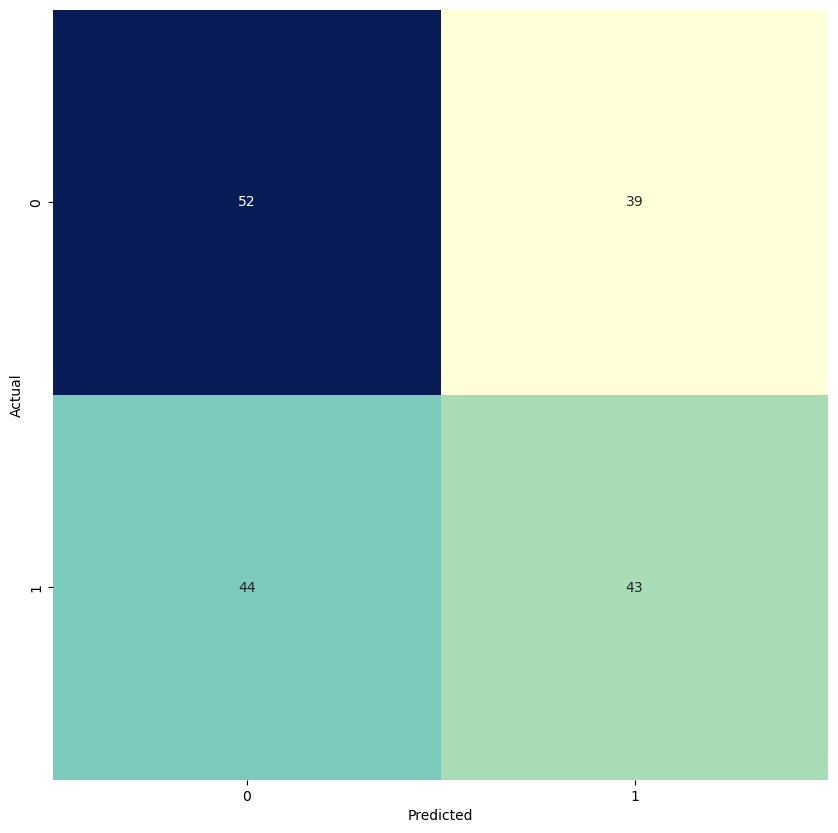

In [65]:
TARGET_MAP = {2 : 1, # Fully Paid
                1 : 0, # Current
                0 : 0, # In Grace Period
                -1 : 0, # Late (16-30 days)
                -2 : 0, # Late (31-120 days)
                -3 : 0, # Charged Off
                }

data.set_df().map_target(TARGET_MAP).downsample(1)
X_train, y_train = data.get_train()
X_test, y_test = data.get_test()

model = TreeModel(is_xgboost=True, enable_categorical=True, class_weight=None)
model.train(X_train, y_train)
cm = model.test(X_test, y_test)
model.plot_confusion_matrix(cm, y_test[TARGET].unique())

Results from running plain XGBoost on binary classification were mixed.  I next tried removing the "Current" values from the training set while setting them to the negative class for testing. Theoretically, people that are current could still default on their loans.  Since there is a level of uncertainty with them and they made up the majority class, I wanted to experiment with not training on them since that could skew the results one way or another.  I also didn't want to remove the data fully from the test set as well since this is a lot of data, and since it is important to understand how the model will be effected by these values as well.

Min class size: 287
[1 1 1 1 1 1 1 1 0 0]
(173,) (173, 1)
Accuracy: 0.50
Precision: 0.59
Recall: 0.50
F1: 0.50
    0   1
0  40  19
1  68  46


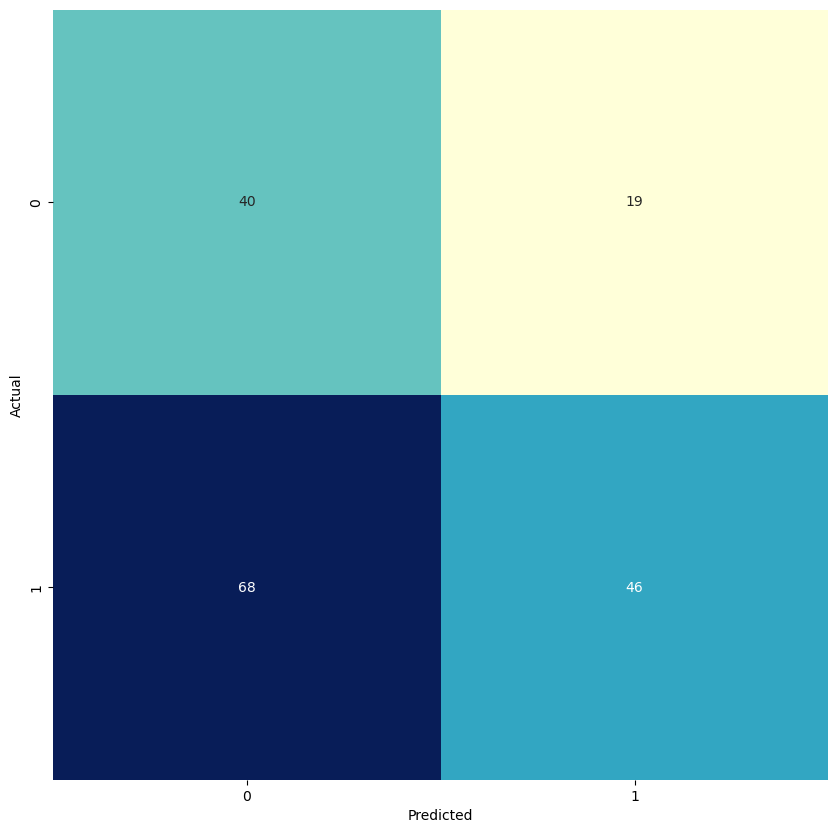

In [66]:
TARGET_MAP = {2 : 1, # Fully Paid
                1 : -1, # Current
                0 : 0, # In Grace Period
                -1 : 0, # Late (16-30 days)
                -2 : 0, # Late (31-120 days)
                -3 : 0, # Charged Off
                }

data.set_df().map_target(TARGET_MAP).downsample()
X_train, y_train = data.get_train()
X_train = X_train[y_train[TARGET] != -1]
y_train = y_train[y_train[TARGET] != -1]
X_test, y_test = data.get_test()
y_test[TARGET] = y_test[TARGET].map({-1: 0, 1: 1, 0: 0})

model = TreeModel(is_xgboost=True, enable_categorical=True, class_weight=None)
model.train(X_train, y_train)
cm = model.test(X_test, y_test)
model.plot_confusion_matrix(cm, y_test[TARGET].unique())

Not training on the current class resulted in a decent precision for the positive class.  However, it did not perform better than the final random forest model.

# PCA Exploration

I also explored incorporating PCA into the models.  However, my results were not as favorable as I had hoped.  I decided to only include my initial steps to demonstrate how I reduced the dimensions along with only one test to show the approach worked. In actuality, I tested a few variations with both XGBoost and Random Forest.

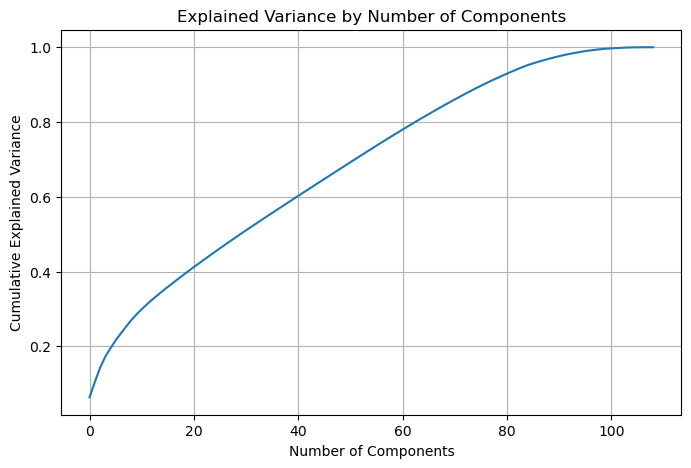

In [67]:
data.set_df().set_pca(True, pca_n_components=0.99999)
# data.pca.plot()




Based on the graph, a cut-off between 0.9 and 0.95 seemed to allow for the most variance to be captured while reducing the number of dimensions.  I decided to use 0.95 as the cut-off for the PCA. 

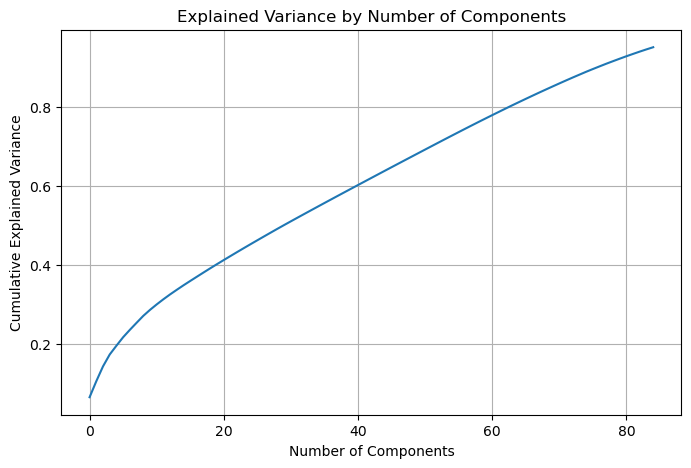

Min class size: 445


In [68]:
TARGET_MAP = {2 : 1, # Fully Paid
                1 : 0, # Current
                0 : 0, # In Grace Period
                -1 : 0, # Late (16-30 days)
                -2 : 0, # Late (31-120 days)
                -3 : 0, # Charged Off
                }

data.set_df().set_pca(True, pca_n_components=0.95).map_target(TARGET_MAP).downsample(1)

{1: 2, 0: 1}


c:\Users\grant\anaconda3\envs\xgboost_gpu\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[0 1 1 0 0 1 0 1 1 1]
(178,) (178, 1)
Accuracy: 0.54
Precision: 0.54
Recall: 0.54
F1: 0.54
    0   1
0  53  38
1  44  43


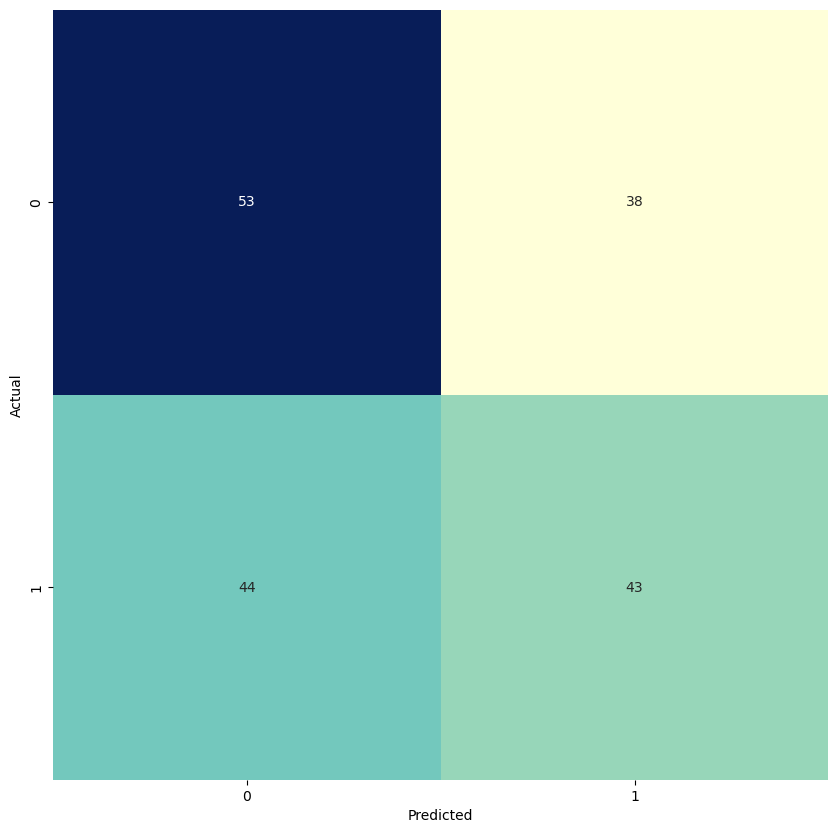

In [69]:
X_train, y_train = data.get_train()
X_test, y_test = data.get_test()

model = TreeModel(is_xgboost=False, enable_categorical=True, class_weight=2)
model.train(X_train, y_train)
cm = model.test(X_test, y_test)
model.plot_confusion_matrix(cm, y_test[TARGET].unique())

# Deep Neural Network

In [70]:
def downsample(df, target_col, modifier=1):
    min_class_size = df[target_col].value_counts().min()
    min_class_size = int(min_class_size * modifier)

    df = df.groupby(target_col).apply(lambda x: x.sample(min_class_size) if len(x) > min_class_size else x).reset_index(drop=True)
    return df

def train_test(df, target_col, test_size=0.2):
    X = df.drop(target_col, axis=1)
    y = df[[target_col]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    
    return X_train, X_test, y_train, y_test

def build_dataloaders(df, target_col, test_size=0.2, batch_size=32):
    X_train, X_test, y_train, y_test = train_test(df, target_col, test_size)
    
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.squeeze().values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.squeeze().values, dtype=torch.long)
    
    

    # train_data = TensorDataset(torch.from_numpy(X_train.values).float(), torch.from_numpy(y_train.squeeze().values).float())
    # test_data = TensorDataset(torch.from_numpy(X_test.values).float(), torch.from_numpy(y_test.squeeze().values).float())
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [71]:
class SimpleDNN(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        # Takes in an input_size, a list of hidden_layers, and an output_size
        super(SimpleDNN, self).__init__()
        # Define the network layers dynamically
        layers = [nn.Linear(input_size, hidden_layers[0])]
        layers += [nn.Linear(hidden_layers[i], hidden_layers[i+1]) for i in range(len(hidden_layers)-1)]
        layers.append(nn.Linear(hidden_layers[-1], output_size))

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        # Apply all but the last layer with ReLU activation
        for i in range(len(self.layers) - 1):
            x = F.relu(self.layers[i](x))
        x = self.layers[-1](x)
        return x

In [72]:
# Setup
INPUT_DATA = './data/normalized_with_dummies_no_na.csv'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {DEVICE} device')
LR = 0.00001
NUM_EPOCHS = 50

SAVE_FREQ = 50

Using cuda device


In [73]:
# Prepare the data
df_orig = pd.read_csv(INPUT_DATA)

df = df_orig.copy()

TARGET_DICT = {2 : True, # Fully Paid
                1 : False, # Current
                0 : False, # In Grace Period
                -1 : False, # Late (16-30 days)
                -2 : False, # Late (31-120 days)
                -3 : False, # Charged Off
                }

df[TARGET] = df[TARGET].map(TARGET_DICT)

df = downsample(df, TARGET, modifier=1.5)

train_loader, test_loader = build_dataloaders(df, TARGET, test_size=0.2, batch_size=32)

In [74]:
# Prepare the model

input_size = len(df.columns) - 1 
hidden_layers = [128, 256,  16] #64, 32,
output_size = len(df[TARGET].unique())

print(input_size, output_size)
model = SimpleDNN(input_size, hidden_layers, output_size)
print(model)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss() # Cross entropy loss used since we are working with classification

# Having a scheduler and gradient clipping is a bit overkill for this simple problem, but it's good to be thorough
max_grad_norm = 1 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

118 2
SimpleDNN(
  (layers): ModuleList(
    (0): Linear(in_features=118, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [75]:
# Training Loop

for epoch in range(NUM_EPOCHS):
    epoch_number = epoch
    model.train()
    total_loss = 0
    strt = time()

    # Training Loop
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        if torch.isnan(loss).any() or torch.isinf(loss).any():
            print("NaN or Inf loss encountered")
            continue

        loss.backward()

        for p in model.parameters():
            if p.grad is not None and (torch.isnan(p.grad).any() or torch.isinf(p.grad).any()):
                print("NaN or Inf in gradients")
                continue
        
        # Again, a little overkill
        clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    end = time()
    print(f"Epoch {epoch_number+1}/{NUM_EPOCHS}, Training Loss: {total_loss / len(train_loader)}, Time: {end-strt}, lr: {scheduler.get_last_lr()[0]}")

    # Testing Loop
    model.eval()
    correct = 0
    total = 0
    strt = time()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            outputs = outputs.to("cpu")
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    end = time()
    print(f"Epoch {epoch_number+1}/{NUM_EPOCHS}, Test Accuracy: {100 * correct / total}%, Time: {end-strt}")

    # Save the model
    if (epoch % SAVE_FREQ == 0  and epoch != 0) or epoch == SAVE_FREQ - 1:
        torch.save(model.state_dict(), f'model_epoch_{epoch_number}.pth')

print("Training complete.")

Epoch 1/50, Training Loss: 135.86912291390556, Time: 0.13051486015319824, lr: 1e-05
Epoch 1/50, Test Accuracy: 54.7085201793722%, Time: 0.00620722770690918
Epoch 2/50, Training Loss: 86.95440305982318, Time: 0.13657855987548828, lr: 1e-05
Epoch 2/50, Test Accuracy: 58.74439461883408%, Time: 0.007344961166381836
Epoch 3/50, Training Loss: 66.68104812077114, Time: 0.10828161239624023, lr: 1e-05
Epoch 3/50, Test Accuracy: 58.29596412556054%, Time: 0.0062525272369384766
Epoch 4/50, Training Loss: 52.11725630078997, Time: 0.104736328125, lr: 1e-05
Epoch 4/50, Test Accuracy: 55.15695067264574%, Time: 0.0068950653076171875
Epoch 5/50, Training Loss: 42.19805635724749, Time: 0.11547493934631348, lr: 1e-05
Epoch 5/50, Test Accuracy: 60.98654708520179%, Time: 0.007999420166015625
Epoch 6/50, Training Loss: 36.38560741288321, Time: 0.10570836067199707, lr: 1e-05
Epoch 6/50, Test Accuracy: 62.780269058295964%, Time: 0.006006002426147461
Epoch 7/50, Training Loss: 31.614839247294835, Time: 0.095016

In [76]:
def test(y_pred, y_test):
        
    print(y_pred.shape, y_test.shape)
    
    accuracy = accuracy_score(y_test, y_pred)
    method = "weighted"
    precision = precision_score(y_test, y_pred, average=method)
    recall = recall_score(y_test, y_pred, average=method)
    f1 = f1_score(y_test, y_pred, average=method)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1: {f1:.2f}")
    
    cm = confusion_matrix(y_test, y_pred)
    labels = y_test[TARGET].unique().tolist()
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    ordered_labels = sorted(labels)
    cm_df = cm_df.reindex(index=ordered_labels, columns=ordered_labels) #, fill_value=0) 
    
    # print(cm)

    # return cm
    print(cm_df)
    return cm_df

def plot_confusion_matrix(cm):
    # Plots the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False) #, xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

(223, 1) (223, 1)
Accuracy: 0.56
Precision: 0.58
Recall: 0.56
F1: 0.57
    0   1
0  85  58
1  40  40


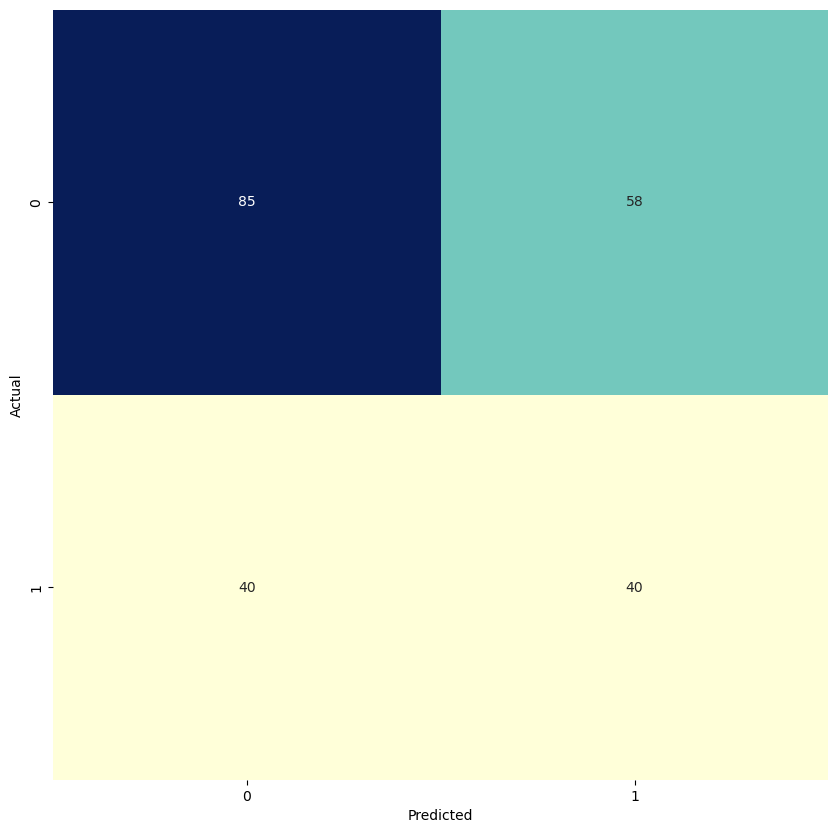

In [77]:
y_pred = []
y_test = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        outputs = outputs.to("cpu")
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        y_test.extend(labels.tolist())

y_pred = pd.DataFrame(y_pred, columns=[TARGET])
y_test = pd.DataFrame(y_test, columns=[TARGET])

cm = test(y_pred, y_test)
plot_confusion_matrix(cm)



Given more hyperparameter tooning, time, and a bit more data, I am confident the DNN could match or outperfomr both the Random Forest and XGBoost models.  However, I was not able to fully explore these possibilities.  I only included the initial steps to demonstrate how I built the model and tested it.

# Takeaways

While I feel that some of the models are able to capture the information we truly care about (minimizing the number of loans we falsely classify will be fully paid), I would have liked to produce a model with better results overall.  Given a bit more time, I would have further explored working with deep neural networks.  I would have also explored feature selection to reduce the amount of noise being passed into the traditional models.